## Get data

In [1]:
#imports
from astroquery.gaia import Gaia
import pandas as pd 
import seaborn as sns
import math
import matplotlib.pyplot as plt

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


In [2]:
#gaia query

job = Gaia.launch_job_async("SELECT ALL gaia_source.source_id,gaia_source.ra,gaia_source.dec,\
gaia_source.pmra,gaia_source.pmdec,gaia_source.phot_bp_mean_mag FROM gaiadr2.gaia_source WHERE CONTAINS\
(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),CIRCLE('ICRS',229.226,7.002,0.3))=1")  
                           # AND  \(gaiadr2.gaia_source.phot_bp_mean_mag<=20)")

Query finished.


In [3]:
#get resulting gaia datatable
r = job.get_results() #print(r['ra','dec'])
df_gaia = r.to_pandas()

In [4]:
#read apt datatable
filename = "pi26133_001.csv"
df_apt_ = pd.read_csv(filename) 
df_apt = df_apt_[['CentroidRA', 'CentroidDec','Magnitude', 'MagUncertainty']]

## Plots

Text(0.5,1,'Position match')

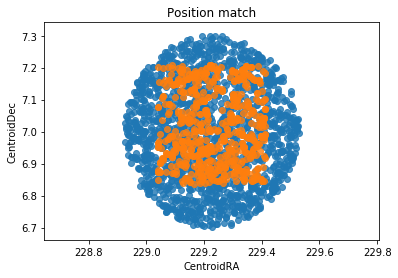

In [5]:
#check ra and dec matching
sns.regplot('ra', 'dec', data=df_gaia, fit_reg = False)
sns.regplot('CentroidRA', 'CentroidDec', data=df_apt, fit_reg = False).set_title("Position match")

In [27]:
#set diff
maxdiff = 0.0050 #degree

m = 0
df_gaia = df_gaia.sort_values('ra').reset_index(drop=True)
df_temp = pd.DataFrame(columns=['ra','dec','phot_bp_mean_mag'])
df = pd.DataFrame(columns=['ra','dec','phot_bp_mean_mag','CentroidRA','CentroidDec','Magnitude','diff','pmra','pmdec'])

while m < len(df_apt):
    n = 0
    df_temp = pd.DataFrame(columns=['ra','dec','phot_bp_mean_mag'])
    while n<len(df_gaia):
        if df_apt['CentroidRA'][m] - maxdiff > df_gaia['ra'][n]: 
            n+=1
        elif df_apt['CentroidRA'][m] - maxdiff <= df_gaia['ra'][n] <= df_apt['CentroidRA'][m] + maxdiff :
            if df_apt['CentroidDec'][m] - maxdiff <= df_gaia['dec'][n] <= df_apt['CentroidDec'][m] + maxdiff :
                df_temp = df_temp.append({'ra': df_gaia['ra'][n], 'dec': df_gaia['dec'][n], \
                                          'phot_bp_mean_mag': df_gaia['phot_bp_mean_mag'][n], \
                                          'pmra': df_gaia['pmra'][n],\
                                          'diff':  math.sqrt((df_gaia['ra'][n]-df_apt['CentroidRA'][m])**2+\
                                                             (df_gaia['dec'][n]-df_apt['CentroidDec'][m])**2)},\
                                         ignore_index=True)
            n+=1
        else :
            break
    if m == 0:
        print('Started. Progress:')
    elif m == int(len(df_apt)/10):
        print(' 10% | ██--------------')
    elif m == int(len(df_apt)/4):
        print(' 25% | ████------------')
    elif m == int(len(df_apt)/2):
        print(' 50% | ████████--------')
    elif m == int(len(df_apt)/4*3):
        print(' 75% | ████████████----')
    elif m == len(df_apt)-1:
        print('100% | ████████████████')
    if df_temp.empty == False : 
        df_temp = df_temp.nsmallest(1, 'diff').reset_index(drop=True)
        df = df.append({'ra': df_temp['ra'][0], \
                    'dec': df_temp['dec'][0],\
                    'phot_bp_mean_mag': df_temp['phot_bp_mean_mag'][0],\
                    'CentroidRA': df_apt['CentroidRA'][m],\
                    'CentroidDec': df_apt['CentroidDec'][m],\
                    'Magnitude': df_apt['Magnitude'][m],\
                    'diff': df_temp['diff'][0]}, ignore_index=True)
    m+=1
print('Finished')

Started. Progress:
 10% | ██--------------
 25% | ████------------
 50% | ████████--------
 75% | ████████████----
100% | ████████████████
Finished


/Users/Lyy/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Distribution of difference in match')

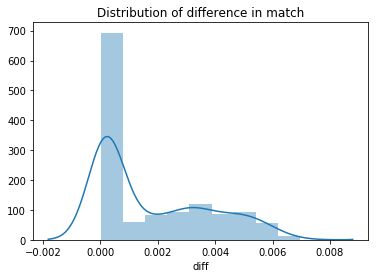

In [28]:
sns.distplot(df['diff']).set_title('Distribution of difference in match')

In [29]:
#new vars
df['Δra'] = df.apply(lambda row: row.ra - row.CentroidRA, axis = 1) 
df['Δdec'] = df.apply(lambda row: row.dec - row.CentroidDec, axis = 1) 
df['Δmag'] = df.apply(lambda row: row.Magnitude - row.phot_bp_mean_mag, axis = 1) 

#subset
df_filtered = df.query('diff<0.001')

/Users/Lyy/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/Lyy/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'dec vs. Δdec')

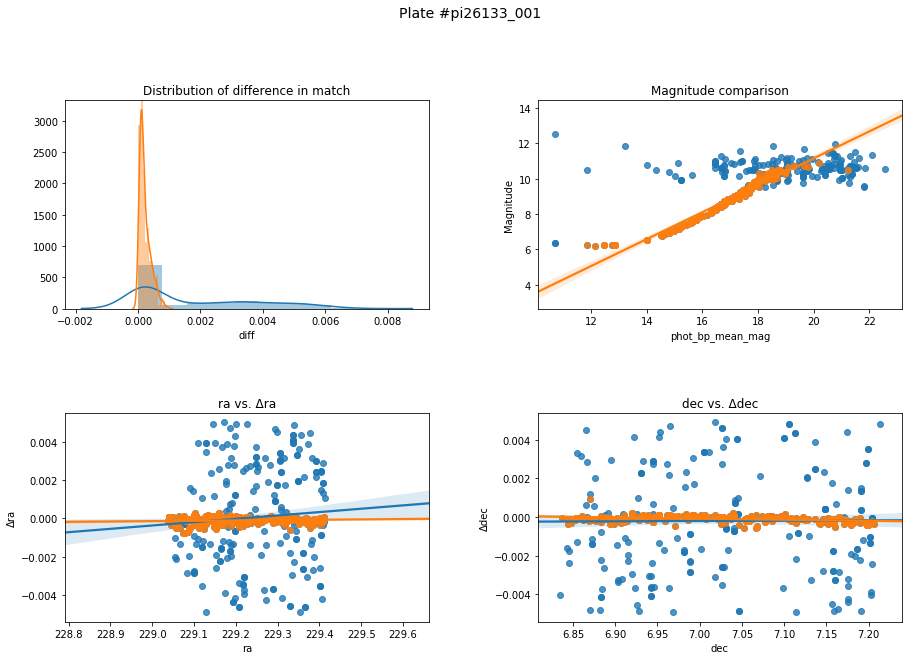

In [16]:
fig = plt.figure(figsize=(15,10))
title = fig.suptitle("Plate #pi26133_001", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3, hspace=0.5)

ax1 = fig.add_subplot(2,2,1)
sns.distplot(df['diff']).set_title('Distribution of difference in match')
sns.distplot(df_filtered['diff']).set_title('Distribution of difference in match')
ax2 = fig.add_subplot(2,2,2)
sns.regplot('phot_bp_mean_mag','Magnitude',data=df, fit_reg = False).set_title('Magnitude comparison')
sns.regplot('phot_bp_mean_mag','Magnitude',data=df_filtered).set_title('Magnitude comparison')
ax3 = fig.add_subplot(2,2,3)
sns.regplot('ra','Δra',data=df).set_title('ra vs. Δra')
sns.regplot('ra','Δra',data=df_filtered).set_title('ra vs. Δra')
ax4 = fig.add_subplot(2,2,4)
sns.regplot('dec','Δdec',data=df).set_title('dec vs. Δdec')
sns.regplot('dec','Δdec',data=df_filtered).set_title('dec vs. Δdec')

ValueError: low >= high

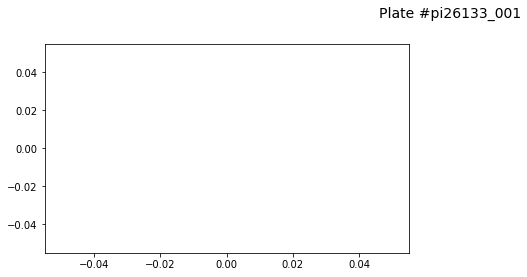

In [17]:
fig = plt.figure(figsize=(15,4))
title = fig.suptitle("Plate #pi26133_001", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax1 = fig.add_subplot(1,2,1)
sns.regplot('pmra','Δra',data=df).set_title('pmra vs. Δra')
sns.regplot('pmra','Δra',data=df_filtered).set_title('pmra vs. Δra')

ax2 = fig.add_subplot(1,2,2)
sns.regplot('pmdec','Δdec',data=df).set_title('pmdec vs. Δdec')
sns.regplot('pmdec','Δdec',data=df_filtered).set_title('pmdec vs. Δdec')

In [30]:
df.sort_values('pmra')

,ra,dec,phot_bp_mean_mag,CentroidRA,CentroidDec,Magnitude,diff,pmra,pmdec,Δra,Δdec,Δmag
0,229.414261,6.922732,20.103594,229.413211,6.918594,10.0865,0.004269,NaN,NaN,0.001050,0.004138,-10.017094
1,229.411337,6.991578,18.249372,229.411529,6.988525,9.5097,0.003059,NaN,NaN,-0.000192,0.003053,-8.739672
2,229.411337,6.991578,18.249372,229.411391,6.991570,9.9756,0.000055,NaN,NaN,-0.000054,0.000008,-8.273772
3,229.406678,7.098313,17.687029,229.410855,7.101983,10.5075,0.005560,NaN,NaN,-0.004177,-0.003670,-7.179529
4,229.410993,7.018372,18.627155,229.410941,7.018296,10.1382,0.000092,NaN,NaN,0.000052,0.000076,-8.488955
5,229.409363,6.981464,20.956434,229.409703,6.983184,10.5509,0.001754,NaN,NaN,-0.000340,-0.001720,-10.405534
6,229.409363,6.981464,20.956434,229.409332,6.983261,10.5133,0.001798,NaN,NaN,0.000031,-0.001797,-10.443134
7,229.409363,6.981464,20.956434,229.409332,6.983259,10.5050,0.001796,NaN,NaN,0.000031,-0.001795,-10.451434
8,229.409198,6.844292,18.982901,229.409403,6.844651,10.4046,0.000414,NaN,NaN,-0.000205,-0.000359,-8.578301
9,229.409630,7.042304,20.764843,229.408329,7.042259,10.8560,0.001302,NaN,NaN,0.001301,0.000045,-9.908843
